In [1]:
from graphviz import Digraph
from IPython.display import display, Image
from collections import deque

In [2]:
# Grafo combinado: (capacidad_autos, capacidad_camiones, distancia_km)
lag = {
    's': [('A', (20, 10, 2)), ('B', (15, 8, 3)), ('C', (10, 7, 4))],
    'A': [('D', (25, 12, 1)), ('E', (10, 6, 2))],
    'B': [('E', (20, 10, 2.5)), ('F', (15, 8, 3))],
    'C': [('F', (10, 5, 4)), ('G', (5, 3, 5))],
    'D': [('H', (30, 15, 1.5))],
    'E': [('H', (20, 10, 2)), ('I', (20, 12, 2.5))],
    'F': [('I', (15, 8, 3)), ('J', (20, 10, 3.5))],
    'G': [('J', (10, 5, 4))],
    'H': [('t', (20, 12, 2))],
    'I': [('t', (20, 15, 2.5))],
    'J': [('t', (20, 10, 3))]
}


In [3]:
# Clase para representar el algoritmo de Edmonds-Karp
class CEK:
    def __init__(self, lag, tipo_transporte='autos'):
        self.grafo = lag
        self.grafo_residual = {}
        self.flujos = {}
        self.tipo_transporte = tipo_transporte  # 'autos' o 'camiones'
        self.CreaGrafoResidual()

    def CreaGrafoResidual(self):
        for nodo in self.grafo:
            if nodo not in self.grafo_residual:
                self.grafo_residual[nodo] = {}
            for vecino, capacidades in self.grafo[nodo]:
                capacidad = capacidades[0] if self.tipo_transporte == 'autos' else capacidades[1]
                if vecino not in self.grafo_residual:
                    self.grafo_residual[vecino] = {}
                self.grafo_residual[nodo][vecino] = capacidad
                if vecino not in self.grafo_residual or nodo not in self.grafo_residual[vecino]:
                    self.grafo_residual[vecino][nodo] = 0  # arista inversa
                if (nodo, vecino) not in self.flujos:
                    self.flujos[(nodo, vecino)] = 0
                if (vecino, nodo) not in self.flujos:
                    self.flujos[(vecino, nodo)] = 0

    def BFS(self, fuente, sumidero, padre):
        visitados = set()
        cola = deque([fuente])
        visitados.add(fuente)
        while cola:
            nodo = cola.popleft()
            for vecino, capacidad in self.grafo_residual[nodo].items():
                if vecino not in visitados and capacidad > 0:
                    padre[vecino] = nodo
                    cola.append(vecino)
                    visitados.add(vecino)
                    if vecino == sumidero:
                        return True
        return False

    def EK(self, fuente, sumidero):
        flujo_maximo = 0
        padre = {}
        while self.BFS(fuente, sumidero, padre):
            camino_flujo = float('inf')
            s = sumidero
            while s != fuente:
                camino_flujo = min(camino_flujo, self.grafo_residual[padre[s]][s])
                s = padre[s]
            v = sumidero
            while v != fuente:
                u = padre[v]
                self.grafo_residual[u][v] -= camino_flujo
                self.grafo_residual[v][u] += camino_flujo
                self.flujos[(u, v)] += camino_flujo
                self.flujos[(v, u)] -= camino_flujo
                v = padre[v]
            flujo_maximo += camino_flujo
        return flujo_maximo

    def muestraFlujos(self):
        for u in self.grafo:
            for v, capacidad in self.grafo[u]:
                if (u, v) in self.flujos and self.flujos[(u, v)] > 0:
                    print(f"Flujo de {u} a {v}: {self.flujos[(u, v)]}/{capacidad}")

In [4]:
def crear_grafo_en_memoria(lag, tipo_transporte):
    dibujo = Digraph(format='png')
    dibujo.graph_attr['rankdir'] = 'LR'  # Direccion del grafo de izquierda a derecha
    
    # Recorremos el grafo
    for origen, aristas in lag.items():
        for destino, (cap_autos, cap_camiones, distancia) in aristas:
            # Seleccionamos la capacidad de acuerdo al tipo de transporte
            if tipo_transporte == 'autos':
                capacidad = cap_autos
                color = 'blue'  # Color para autos
            else:
                capacidad = cap_camiones
                color = 'red'  # Color para camiones

            # Crear la arista con la capacidad y distancia
            etiqueta = f"cap: {capacidad}, dist: {distancia} km"
            dibujo.edge(origen, destino, label=etiqueta, color=color)
    
    # Generar la imagen en memoria
    img_bytes = dibujo.pipe(format='png')
    return img_bytes

# Visualización del grafo para autos
img_autos = crear_grafo_en_memoria(lag, 'autos')

# Visualización del grafo para camiones
img_camiones = crear_grafo_en_memoria(lag, 'camiones')


In [5]:
def calcular_pago_total(cek, lag, factor_pago):
    pago_total = 0
    for u in cek.flujos:
        if cek.flujos[u] > 0:  # Si hay flujo en la arista
            origen, destino = u
            for v, datos in lag.get(origen, []):
                if v == destino:
                    distancia = datos[2]  # La distancia está en la posición 2
                    pago_total += cek.flujos[u] * distancia * factor_pago
                    break
    return pago_total


# Autos

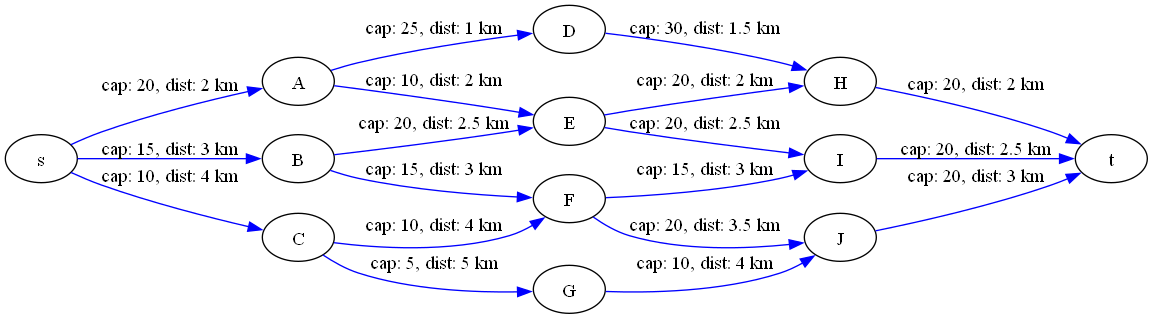

In [6]:
display(Image(img_autos))

In [7]:
ek_autos = CEK(lag, 'autos')
flujo_maximo_autos = ek_autos.EK('s', 't')
print(f"Flujo máximo de autos: {flujo_maximo_autos}")
ek_autos.muestraFlujos()

Flujo máximo de autos: 45
Flujo de s a A: 20/(20, 10, 2)
Flujo de s a B: 15/(15, 8, 3)
Flujo de s a C: 10/(10, 7, 4)
Flujo de A a D: 20/(25, 12, 1)
Flujo de B a E: 15/(20, 10, 2.5)
Flujo de C a F: 10/(10, 5, 4)
Flujo de D a H: 20/(30, 15, 1.5)
Flujo de E a I: 15/(20, 12, 2.5)
Flujo de F a I: 5/(15, 8, 3)
Flujo de F a J: 5/(20, 10, 3.5)
Flujo de H a t: 20/(20, 12, 2)
Flujo de I a t: 20/(20, 15, 2.5)
Flujo de J a t: 5/(20, 10, 3)


In [8]:
pago_autos_con_distancia = calcular_pago_total(ek_autos, lag, 0.80)
print(f"Pago total de autos considerando distancias: {pago_autos_con_distancia} soles")

Pago total de autos considerando distancias: 342.0 soles


# Camiones

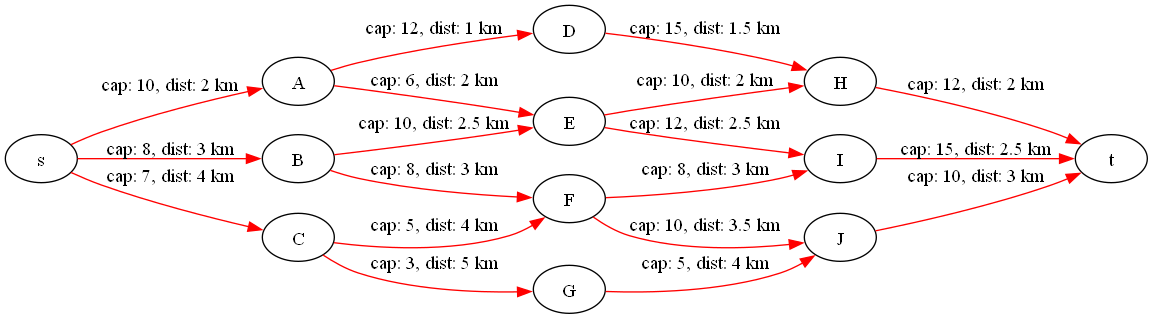

In [9]:
display(Image(img_camiones))

In [10]:
ek_camiones = CEK(lag, 'camiones')
flujo_maximo_camiones = ek_camiones.EK('s', 't')
print(f"Flujo máximo de camiones: {flujo_maximo_camiones}")
ek_camiones.muestraFlujos()

Flujo máximo de camiones: 25
Flujo de s a A: 10/(20, 10, 2)
Flujo de s a B: 8/(15, 8, 3)
Flujo de s a C: 7/(10, 7, 4)
Flujo de A a D: 10/(25, 12, 1)
Flujo de B a E: 8/(20, 10, 2.5)
Flujo de C a F: 5/(10, 5, 4)
Flujo de C a G: 2/(5, 3, 5)
Flujo de D a H: 10/(30, 15, 1.5)
Flujo de E a H: 2/(20, 10, 2)
Flujo de E a I: 6/(20, 12, 2.5)
Flujo de F a I: 5/(15, 8, 3)
Flujo de G a J: 2/(10, 5, 4)
Flujo de H a t: 12/(20, 12, 2)
Flujo de I a t: 11/(20, 15, 2.5)
Flujo de J a t: 2/(20, 10, 3)


In [11]:
pago_camiones_con_distancia = calcular_pago_total(ek_camiones, lag, 1.50)
print(f"Pago total de camiones considerando distancias: {pago_camiones_con_distancia} soles")

Pago total de camiones considerando distancias: 369.75 soles
